In [17]:
from sec_certs.dataset.fips import FIPSDataset
from sec_certs.dataset.cpe import CPEDataset
from sec_certs.dataset.cve import CVEDataset
from sec_certs.utils.pandas import expand_df_with_cve_cols
import pandas as pd
import seaborn as sns
import itertools
import functools
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
dset = FIPSDataset.from_web_latest()
cve_dset: CVEDataset = dset._prepare_cve_dataset()
cpe_dset: CPEDataset = dset._prepare_cpe_dataset()

parsing cpe matching (by NIST) dictionary: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400508/400508 [00:26<00:00, 15291.66it/s]
Building-up lookup dictionaries for fast CVE matching: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198239/198239 [00:09<00:00, 20313.13it/s]


In [6]:
df = dset.to_pandas()
cves = list(itertools.chain.from_iterable(x.heuristics.related_cves for x in dset if x.heuristics.related_cves))
cve_dict = {x: cve_dset[x] for x in cves}
cve_dset.cves = cve_dict # Limit cve_dset to CVEs relevant to some certificate
df = expand_df_with_cve_cols(df, cve_dset)

df_cpe_rich = df.loc[~df.cpe_matches.isnull()].copy()
df_cve_rich = df.loc[df.related_cves.notnull()].copy()

In [7]:
df.head()

,cert_id,name,status,standard,type,level,embodiment,date_validation,date_sunset,algorithms,...,st_directly_referenced_by,st_indirectly_referenced_by,st_directly_referencing,st_indirectly_referencing,year_from,n_cves,cve_published_dates,earliest_cve,worst_cve_score,avg_cve_score
dgst,,,,,,,,,,,,,,,,,,,,,
1a42d5267aba37d7,735,Datacryptor® SONET/SDH v1.00,Historical,FIPS140-2,Hardware,2.0,Multi Chip Standalone,2007-02-06,NaT,"{DSA algorithm # #159 created by None, AES alg...",...,NaN,NaN,NaN,NaN,2007,0,NaN,NaN,NaN,NaN
bfa6b4fe534027ca,3075,Samsung Flash Memory Protector V1.2.1,Active,FIPS140-2,Software Hybrid,1.0,Multi Chip Standalone,2017-12-06,2022-12-05,"{HMAC algorithm # #3126 created by None, SHS a...",...,NaN,NaN,NaN,NaN,2017,0,NaN,NaN,NaN,NaN
3c4ee858b268931a,1336,Microsoft Windows Server 2008 R2 Cryptographic...,Historical,FIPS140-2,Software,1.0,Multi Chip Standalone,2010-08-12,NaT,"{RSA algorithm # #559 created by None, SHS alg...",...,NaN,NaN,NaN,NaN,2010,316,"[2012-12-12, 2010-02-10, 2010-02-10, 2010-08-1...",2008-04-08,10.0,7.286709
e50b6b02d6d90ddc,1766,"ProxySG 9000-10 [1], 9000-20 [2], 9000-20B [3]...",Historical,FIPS140-2,Hardware,2.0,Multi Chip Standalone,2012-07-27,NaT,"{Triple-DES algorithm # #1218 created by None,...",...,NaN,NaN,NaN,NaN,2012,0,NaN,NaN,NaN,NaN
377adeb4cd4096ad,315,Motorola Gold Elite Gateway Secure Card (MGEG SC),Historical,FIPS140-2,Hardware,1.0,Multi Chip Embedded,2003-05-13,NaT,"{Triple-DES algorithm # #82 created by None, A...",...,NaN,NaN,NaN,NaN,2003,0,NaN,NaN,NaN,NaN


In [8]:
len(df_cve_rich)

278

In [9]:
len(df_cpe_rich)

513

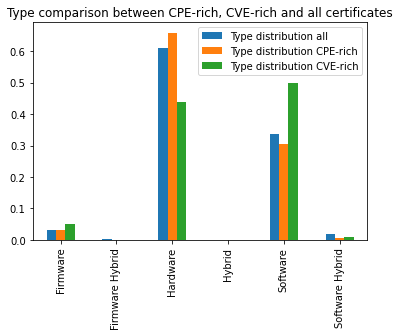

In [13]:
categories_cpe = df_cpe_rich.type.value_counts().sort_index().rename('Type distribution CPE-rich')
categories_cve = df_cve_rich.type.value_counts().sort_index().rename('Type distribution CVE-rich')
categories_all = df.type.value_counts().sort_index().rename('Type distribution all')

categories_merged = pd.concat([categories_all, categories_cpe, categories_cve], axis=1)
categories_merged = categories_merged.div(categories_merged.sum(axis=0), axis=1)

categories_merged.plot.bar(title='Type comparison between CPE-rich, CVE-rich and all certificates');

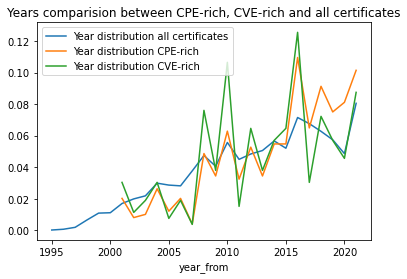

In [14]:
years_cpe = df_cpe_rich.year_from.value_counts().sort_index().rename('Year distribution CPE-rich')
years_cve = df_cve_rich.year_from.value_counts().sort_index().rename('Year distribution CVE-rich')
years_all = df.year_from.value_counts().sort_index().rename('Year distribution all certificates')

years_merged = pd.concat([years_all, years_cpe, years_cve], axis=1)
years_merged.index.name = "year_from"
years_merged = years_merged.loc[years_merged.index < 2022]
years_merged = years_merged.div(years_merged.sum(axis=0), axis=1)
years_merged.plot.line(title='Years comparision between CPE-rich, CVE-rich and all certificates');

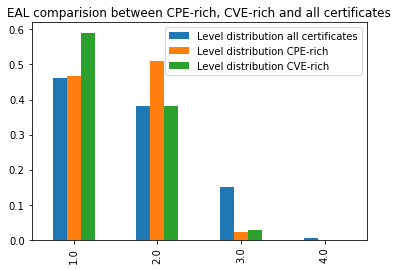

In [15]:
levels_cpe = df_cpe_rich.level.value_counts().sort_index().rename('Level distribution CPE-rich')
levels_cve = df_cve_rich.level.value_counts().sort_index().rename('Level distribution CVE-rich')
levels_all = df.level.value_counts().sort_index().rename('Level distribution all certificates')

levels_merged = pd.concat([levels_all, levels_cpe, levels_cve], axis=1)
levels_merged = levels_merged.div(levels_merged.sum(axis=0), axis=1)
levels_merged.plot.bar(title='EAL comparision between CPE-rich, CVE-rich and all certificates');

In [23]:
spearmanr = functools.partial(stats.spearmanr, nan_policy="omit", alternative="less")
n_cves_level_corr, n_cves_level_pvalue = spearmanr(df_cve_rich.level, df_cve_rich.n_cves)
print(n_cves_level_corr, n_cves_level_pvalue)

worst_cve_level_corr, worst_cve_level_pvalue = spearmanr(df_cve_rich.level, df_cve_rich.worst_cve_score)
print(worst_cve_level_corr, worst_cve_level_pvalue)

avg_cve_level_corr, avg_cve_level_pvalue = spearmanr(df_cve_rich.level, df_cve_rich.avg_cve_score)
print(avg_cve_level_corr, avg_cve_level_pvalue)

-0.7014575524888043 8.642059914383105e-43
-0.7315824610567971 3.940161217161724e-48
-0.3627281950234617 2.269867935814956e-10


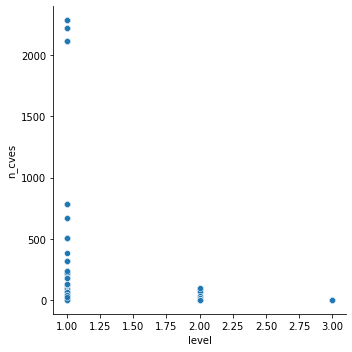

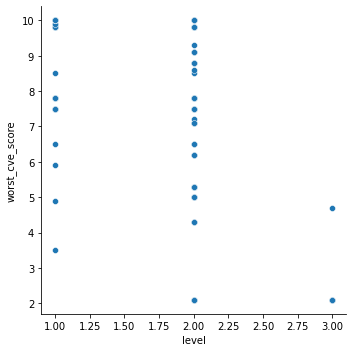

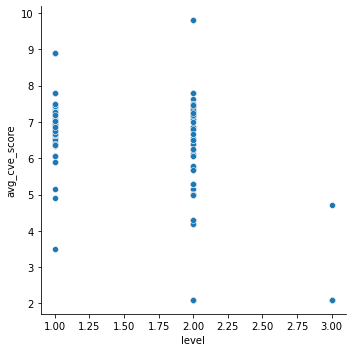

In [29]:
g = sns.relplot(data=df_cve_rich, x="level", y="n_cves")
plt.show()
g = sns.relplot(data=df_cve_rich, x="level", y="worst_cve_score")
plt.show()
g = sns.relplot(data=df_cve_rich, x="level", y="avg_cve_score")
plt.show()